Imports

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from PIL import Image
from tqdm import tqdm

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

Loading & Inspecting the Dataset

In [ ]:
data_dir = Path("/content/image")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)            # set of all unique characters

print("Total images found: ", len(images))
print("Total labels found: ", len(labels))
print("Total number of unique characters: ", len(characters))
print("\n\nCharacter Vocabulary:\n", characters)

In [ ]:
images

In [ ]:
labels


In [ ]:
image_path = images[0]
image = Image.open(image_path)

# Get the size of the image
img_width, img_height = image.size

# Display the image
plt.imshow(image)
plt.title(f"Image size - Width: {img_width}, Height: {img_height}")
plt.axis('off')
plt.show()

In [ ]:
# Maximum length of any captcha in the dataset

max_length = max([len(label) for label in labels])
print("Max Length of labels: ", max_length)

In [ ]:

count1 = 0
for image_path in tqdm(images):
    # Open the image using PIL
    temp_image = Image.open(image_path)

    # Get the size of the image
    temp_width, temp_height = temp_image.size

    if (temp_width != img_width) or (temp_height != img_height):
        count1 += 1

print(f"Number of images whose size is not {img_width} X {img_height}: {count1}")

In [ ]:

for label in tqdm(labels):
    count2 = 0
    if len(label) != max_length:
        count2 += 1

print(f"Number of images whose label size is not {max_length}: {count2}")

Preprocessing the Dataset

In [ ]:

# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), num_oov_indices=1, mask_token=None
)
# Number of out-of-vocabulary (OOV) is set at 1. The encoded integer 0 corresponds to all [UNK]
# characters outside the vocabulary

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [ ]:

# Test string
dummy_label = "pPGP1"

# Convert string to integers using char_to_num
integer_sequence = char_to_num(tf.strings.unicode_split(dummy_label, input_encoding="UTF-8"))

# Convert integers back to string using num_to_char
reconstructed_string = tf.strings.reduce_join(num_to_char(integer_sequence), axis=-1)

# Print the results
print("Original Label:", dummy_label)
print("Integer Sequence:", integer_sequence.numpy())
print("Reconstructed Label:", reconstructed_string.numpy())

In [ ]:
char_to_num_mapping = dict(zip(char_to_num.get_vocabulary(), range(char_to_num.vocabulary_size())))

# Get the vocabulary and indices from num_to_char
num_to_char_mapping = dict(zip(range(num_to_char.vocabulary_size()), num_to_char.get_vocabulary()))

# Print the mappings
print("Character to Integer Mapping:")
print(char_to_num_mapping)

print("\nInteger to Character Mapping:")
print(num_to_char_mapping)

In [ ]:

def split_data(images, labels, train_size=0.7, valid_size = 0.15, shuffle=True):
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)

    train_samples = int(size * train_size)
    valid_samples = int(size * valid_size)

    #print(train_samples, valid_samples)


    # Split data into training, validation and testing sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples: train_samples + valid_samples]], labels[indices[train_samples: train_samples + valid_samples]]
    x_test, y_test = images[indices[train_samples + valid_samples:]], labels[indices[train_samples + valid_samples:]]

    return x_train, x_valid, x_test, y_train, y_valid, y_test


# Splitting data into training and validation sets
x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(np.array(images), np.array(labels))

In [ ]:
print(f"Size of x_train: {len(x_train)}")
print(f"Size of y_train: {len(y_train)}")
print(f"Size of x_valid: {len(x_valid)}")
print(f"Size of y_valid: {len(y_valid)}")
print(f"Size of x_test: {len(x_test)}")
print(f"Size of y_test: {len(y_test)}")

Creating Dataset Instances

In [ ]:
def preprocess_image(img_path, label):
    img = tf.io.read_file(img_path)
    # Decode and convert to grayscale with a single channel
    img = tf.io.decode_jpeg(img, channels=1)
    # Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # Transpose the image because we want the time dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # Map the characters in label to numbers
    label = tf.cast(
    char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8")),
    tf.int32
    )

    # Return a dictionary of image mapped to its label as the model expects two inputs
    return {"image": img, "label": label}

In [ ]:

img_label = preprocess_image(images[0], labels[0])
img_label["image"].shape

In [ ]:
# Batch size for training, validation and testing
batch_size = 64

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [ ]:
def preprocess_and_batch(dataset):
    return (dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                   .batch(batch_size)
                   .prefetch(buffer_size=tf.data.experimental.AUTOTUNE))

train_dataset = preprocess_and_batch(train_dataset)
validation_dataset = preprocess_and_batch(validation_dataset)
test_dataset = preprocess_and_batch(test_dataset)

In [ ]:
# Print dataset sizes
print(f"No. of batches in train_dataset: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"No. of batches in  validation_dataset: {tf.data.experimental.cardinality(validation_dataset).numpy()}")
print(f"No. of batches in  test_dataset: {tf.data.experimental.cardinality(test_dataset).numpy()}")

In [ ]:
# Checking the shape of images and labels in each batch

for batch in train_dataset:
    images = batch["image"]
    labels = batch["label"]
    print("Image Batch Shape: ", images.shape)
    print("Labels Batch Shape: ", labels.shape)
    #print(labels)
    break

Visualizing the Train Dataset

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(21, 6))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

Create the OCR Model

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [ ]:
def residual_block(x, num_filters, kernel_size=(3, 3), activation="leaky_relu", kernel_initializer="he_normal", padding="same"):
    # Shortcut
    shortcut = x

    # First convolutional layer
    x = layers.Conv2D(num_filters, kernel_size, activation=activation, kernel_initializer= kernel_initializer, padding=padding)(x)
    x = layers.BatchNormalization()(x)

    # Second convolutional layer
    x = layers.Conv2D(num_filters, kernel_size, activation=None, kernel_initializer= kernel_initializer, padding=padding)(x)

    # Add shortcut to the output
    x = layers.Add()([x, shortcut])
    x = layers.Activation(activation)(x)
    x = layers.BatchNormalization()(x)

    return x

In [ ]:
def OCR_model():
    # Inputs layer
    input_img = layers.Input(shape=(img_width, img_height, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="int32")

    # First block
    x = layers.Conv2D(32, (3, 3), activation="leaky_relu", kernel_initializer="he_normal", padding="same")(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = residual_block(x, 32)  # Add a residual block
    x = layers.Dropout(0.2)(x)
    x = residual_block(x, 32)  # Add a residual block
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second block
    x = layers.Conv2D(64, (3, 3), activation="leaky_relu", kernel_initializer="he_normal", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = residual_block(x, 64)  # Add a residual block
    x = layers.Dropout(0.2)(x)
    x = residual_block(x, 64)  # Add a residual block
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Third block
    x = layers.Conv2D(128, (3, 3), activation="leaky_relu", kernel_initializer="he_normal", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = residual_block(x, 128)  # Add a residual block
    x = layers.Dropout(0.2)(x)
    x = residual_block(x, 128)  # Add a residual block
    x = layers.MaxPooling2D((2, 2), name="pool3")(x)

    # Three max pool layers have been used with pool size and strides 2.
    # Hence, downsampled feature maps are 8x smaller. The number of
    # filters in the last layer is 128. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 8), (img_height // 8) * 128)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2))(x)

    # Output layer
    x = layers.Dense(len(characters) + 2, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_model_v2")

    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=0.001)

    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = OCR_model()
model.summary()

Train the Neural Network

In [ ]:
epochs = 100
early_stopping_patience = 10

# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Add ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, verbose=1, mode="min", min_lr=1e-7,
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
)

In [ ]:
additional_epochs = 10

history_additional = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs + additional_epochs,  # Set the total number of epochs
    callbacks=[early_stopping, reduce_lr],
    initial_epoch=epochs,  # Specify the starting epoch (optional)
)

In [ ]:
additional_epochs2 = 10
new_learning_rate = 0.0001  # Manually enforcing reduced learning rate

# Change the learning rate in the optimizer
model.optimizer.learning_rate.assign(new_learning_rate)

# Continue training for additional epochs
additional_history2 = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs + additional_epochs + additional_epochs2,
    callbacks=[early_stopping, reduce_lr],
    initial_epoch=epochs + additional_epochs
)

In [ ]:
additional_epochs3 = 55
new_learning_rate = 0.00001  # Manually enforcing reduced learning rate

# Change the learning rate in the optimizer
model.optimizer.learning_rate.assign(new_learning_rate)

# Continue training for additional epochs
additional_history3 = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs + additional_epochs + additional_epochs2 + additional_epochs3,
    callbacks=[early_stopping, reduce_lr],
    initial_epoch=epochs + additional_epochs + additional_epochs2
)

Loss Curve

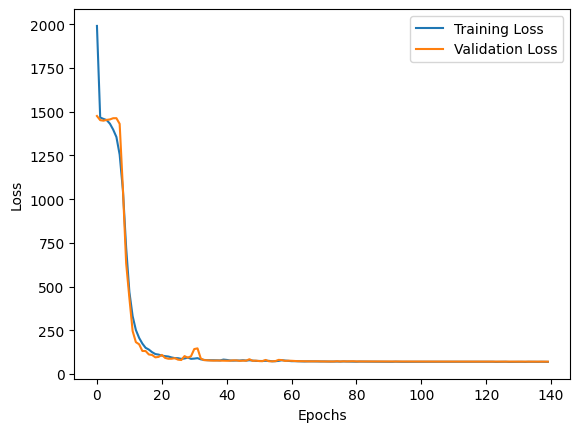

In [ ]:
combined_history = {}
for key in history.history:
    combined_history[key] = history.history[key] + history_additional.history[key] + additional_history2.history[key] + additional_history3.history[key]



# Plot the combined loss curve

plt.plot(combined_history['loss'], label='Training Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Predictions on the Test Dataset

In [ ]:
# Get the prediction model by extracting layers till the output layer
# prediction_model = keras.models.Model(
#     model.get_layer(name="image").input, model.get_layer(name="dense2").output
# )
prediction_model = keras.Model(model.inputs[0], model.layers[-2].output)

prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in test_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    #for i in range(len(pred_texts)):
    for i in range(16):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

Computing the Global (Whole Text-level) Accuracy for the Training, Validation and Test Data

In [ ]:

correct_predictions_Global = 0
total_samples_Global = 0


for batch in test_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for pred_text, label_text in zip(pred_texts, batch_labels):
        label_text = tf.strings.reduce_join(num_to_char(label_text)).numpy().decode("utf-8")
        total_samples_Global += 1

        if pred_text == label_text:
            correct_predictions_Global += 1


# Calculate Global accuracy
global_accuracy = correct_predictions_Global / total_samples_Global
print(f"\n\n\n\nOverall Global Accuracy: {global_accuracy * 100:.2f}%")

Normalizing the Actual text

In [ ]:
results = []
def decode_labels(labels):
    texts = []
    for label in labels:
        chars = num_to_char(label)
        text = tf.strings.reduce_join(chars).numpy().decode("utf-8")
        texts.append(text)
    return texts
for batch in validation_dataset:
    preds = prediction_model.predict(batch["image"])

    pred_texts = decode_batch_predictions(preds)
    true_texts = decode_labels(batch["label"])

    for t, p in zip(true_texts, pred_texts):
        results.append([t, p, t == p])

In [ ]:
import pandas as pd
df = pd.DataFrame(results, columns=["Actual", "Predicted", "Correct"])

In [ ]:
df

,Actual,Predicted,Correct
0,8VQAFM,8VQAFM,True
1,WMVYDQ,WMVYDQ,True
2,GG2WDK,GG2WDK,True
3,3QKC62,3QKC62,True
4,QO9XBQ,QO9XBQ,True
...,...,...,...
385,SKQKBM,SKQKBM,True
386,8DQMWG,8DQMWG,True
387,WQBLAV,WQBLAV,True
388,s65suw,S65SUW,False


In [ ]:
metric_df=df.copy()

In [ ]:
metric_df["Actual_normalized"] = metric_df["Actual"].str.upper().str.replace(" ", "", regex=False)

In [ ]:
metric_df.head()

,Actual,Predicted,Correct,Actual_normalized
0,8VQAFM,8VQAFM,True,8VQAFM
1,WMVYDQ,WMVYDQ,True,WMVYDQ
2,GG2WDK,GG2WDK,True,GG2WDK
3,3QKC62,3QKC62,True,3QKC62
4,QO9XBQ,QO9XBQ,True,QO9XBQ


In [ ]:
metric_df["Status"]=metric_df["Actual_normalized"]==metric_df["Predicted"]

In [ ]:
metric_df.value_counts("Status")

,count
Status,
True,390


Model Inference

In [ ]:
def preprocess_image_infer(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.transpose(img, perm=[1,0,2])
    return img

# def predict_image(path):

#     img = preprocess_image_infer(path)
#     img = tf.expand_dims(img, axis=0)

#     pred = prediction_model.predict(img)
#     text = decode_batch_predictions(pred)[0]

#     return text


# print(predict_image("/content/89NBB8.png"))


# =========================
# FOLDER INFERENCE
# =========================
def predict_folder(folder):

    images = []
    names = []

    for file in os.listdir(folder):
        path = os.path.join(folder,file)

        images.append(preprocess_image_infer(path))
        names.append(file)

    images = tf.stack(images)

    preds = prediction_model.predict(images)
    texts = decode_batch_predictions(preds)

    df = pd.DataFrame({
        "Image": names,
        "Prediction": texts
    })

    return df

temp_df = predict_folder("/content/image_inference")
print(temp_df)

In [96]:
model_inference_df=temp_df.copy()

In [168]:
model_inference_df

,Image,Prediction,Actual,Status
0,LHEZKA.png,LHEZKA,LHEZKA,True
1,T5BIB4.png,T5BIB4,T5BIB4,True
2,iEHE83.png,IEHE83,IEHE83,True
3,ZEU9J2.png,ZEU9J2,ZEU9J2,True
4,LRLYA7.png,LRLYA7,LRLYA7,True
...,...,...,...,...
3252,1L3Y3B.png,1L3Y3B,1L3Y3B,True
3253,elsb17.png,ELSB17,ELSB17,True
3254,5JBP15.png,5JBP15,5JBP15,True
3255,9E451T.png,9E451T,9E451T,True


In [98]:
model_inference_df['Actual'] = model_inference_df['Image'].str[:-4].str.upper()

In [99]:
model_inference_df

,Image,Prediction,Actual
0,LHEZKA.png,LHEZKA,LHEZKA
1,T5BIB4.png,T5BIB4,T5BIB4
2,iEHE83.png,IEHE83,IEHE83
3,ZEU9J2.png,ZEU9J2,ZEU9J2
4,LRLYA7.png,LRLYA7,LRLYA7
...,...,...,...
3252,1L3Y3B.png,1L3Y3B,1L3Y3B
3253,elsb17.png,ELSB17,ELSB17
3254,5JBP15.png,5JBP15,5JBP15
3255,9E451T.png,9E451T,9E451T


In [100]:
model_inference_df["Status"]=model_inference_df["Prediction"]==model_inference_df["Actual"]

In [101]:
model_inference_df[model_inference_df["Status"]==False]

,Image,Prediction,Actual,Status
28,LJJFXO.png,LJFXO[UNK],LJJFXO,False
35,LTHNPS.png,LHNPS[UNK],LTHNPS,False
96,tjjua7.png,TJUA7[UNK],TJJUA7,False
102,jcnltu.png,JCNLU[UNK],JCNLTU,False
107,KIIVRF.png,KIVRF[UNK],KIIVRF,False
...,...,...,...,...
3177,FII6LV.png,FI6LV[UNK],FII6LV,False
3189,LTY1AI.png,LDY1AI,LTY1AI,False
3217,KBIJJZ.png,KBIJZ[UNK],KBIJJZ,False
3231,1LTDZM.png,1LDZM[UNK],1LTDZM,False


**Metrics Evaluation**

Exact Match Accuracy (Word Accuracy)

Measures: How many CAPTCHAs are 100% correct.

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score

metric_df = model_inference_df.copy()

predictions = metric_df["Prediction"].astype(str).tolist()
truths = metric_df["Actual"].astype(str).tolist()
def exact_match_accuracy(predictions, truths):
    correct = sum(p == t for p, t in zip(predictions, truths))
    return correct / len(truths)

exact_acc = exact_match_accuracy(predictions, truths)

print("\n🔷 Exact Match Accuracy")
print(f"Value: {exact_acc:.4f}")


Character Accuracy

Measures: How many characters are correct overall.

In [ ]:
def character_accuracy(predictions, truths):
    total_chars = 0
    correct_chars = 0

    for p, t in zip(predictions, truths):
        total_chars += len(t)
        min_len = min(len(p), len(t))
        for i in range(min_len):
            if p[i] == t[i]:
                correct_chars += 1

    return correct_chars / total_chars

char_acc = character_accuracy(predictions, truths)

print("\n🔷 Character Accuracy")
print(f"Value: {char_acc:.4f}")

Average Length Error

Measures: Difference in predicted vs actual string length.

In [ ]:
def average_length_error(predictions, truths):
    errors = [abs(len(p) - len(t)) for p, t in zip(predictions, truths)]
    return np.mean(errors)

length_error = average_length_error(predictions, truths)
print("Average Length Error:", round(length_error, 4))

Precision, Recall, F1 (Character-Level)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = []
y_pred = []

for p, t in zip(predictions, truths):
    min_len = min(len(p), len(t))
    y_true.extend(list(t[:min_len]))
    y_pred.extend(list(p[:min_len]))

precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")

print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))

CTC Loss

In [ ]:
print("\n🔷 CTC Loss")

final_train_loss = history.history["loss"][-1]
final_val_loss = history.history["val_loss"][-1]

print("Final Training Loss:", round(final_train_loss, 4))
print("Final Validation Loss:", round(final_val_loss, 4))

Inference Time

In [ ]:
import time

start = time.time()

for batch in test_dataset:
    images = batch["image"] if isinstance(batch, dict) else batch[0]
    _ = prediction_model.predict(images, verbose=0)

end = time.time()

total_time = end - start

print("\n🔷 Total Inference Time")
print("Total Time (seconds):", round(total_time, 4))

Inference Latency

In [ ]:
total_samples = 0

for batch in test_dataset:
    images = batch["image"] if isinstance(batch, dict) else batch[0]
    total_samples += images.shape[0]

latency = total_time / total_samples

print("\n🔷 Inference Latency")
print("Latency per Image (seconds):", round(latency, 6))


Throughput

In [ ]:
throughput = total_samples / total_time

print("\n🔷 Throughput")
print("Images per Second:", round(throughput, 2))

Prediction Confidence

In [ ]:
import numpy as np

all_confidences = []

for batch in test_dataset:
    images = batch["image"] if isinstance(batch, dict) else batch[0]
    y_pred = prediction_model.predict(images, verbose=0)

    max_probs = np.max(y_pred, axis=-1)
    batch_conf = np.mean(max_probs, axis=1)

    all_confidences.extend(batch_conf)

avg_confidence = np.mean(all_confidences)

print("\n🔷 Prediction Confidence")
print("Average Confidence:", round(avg_confidence, 4))


Metrics on a New Batch

In [ ]:
import os
import cv2
import numpy as np

def load_new_batch(folder_path, img_width=201, img_height=61):
    images = []
    image_names = []

    for file in os.listdir(folder_path):
        if file.endswith(".jpg") or file.endswith(".png"):
            path = os.path.join(folder_path, file)

            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_width, img_height))
            img = img / 255.0
            img = np.expand_dims(img, axis=-1)

            # If you used transpose during training:
            img = np.transpose(img, (1, 0, 2))

            images.append(img)
            image_names.append(file)

    return np.array(images), image_names

# Example:
new_images, image_names = load_new_batch("/content/new_image")

print("Loaded New Batch Shape:", new_images.shape)


CTC Loss


In [ ]:
print("\n🔷 CTC Loss")

final_train_loss = history.history["loss"][-1]
final_val_loss = history.history["val_loss"][-1]

print("Final Training Loss:", round(final_train_loss, 4))
print("Final Validation Loss:", round(final_val_loss, 4))
print("Loss Gap:", round(final_val_loss - final_train_loss, 4))

Inference Time

In [ ]:

import time

start = time.time()

y_pred = prediction_model.predict(new_images, verbose=0)

end = time.time()

total_time = end - start

print("\n🔷 Total Inference Time (New Batch)")
print("Total Time (seconds):", round(total_time, 4))


Inference Latency (Per Image)

In [ ]:
total_samples = 0

for batch in test_dataset:
    images = batch["image"] if isinstance(batch, dict) else batch[0]
    total_samples += images.shape[0]

latency = total_time / total_samples

print("\n🔷 Inference Latency")
print("Latency per Image (seconds):", round(latency, 6))


Throughput

In [ ]:
throughput = total_samples / total_time

print("\n🔷 Throughput")
print("Images per Second:", round(throughput, 2))


Prediction Confidence

In [ ]:
import numpy as np

all_confidences = []

for batch in test_dataset:
    images = batch["image"] if isinstance(batch, dict) else batch[0]
    y_pred = prediction_model.predict(images, verbose=0)

    max_probs = np.max(y_pred, axis=-1)
    batch_conf = np.mean(max_probs, axis=1)
    all_confidences.extend(batch_conf)

avg_confidence = np.mean(all_confidences)

print("\n🔷 Prediction Confidence")
print("Average Confidence:", round(avg_confidence, 4))


Gradient Norm

In [ ]:
import os
import cv2
import numpy as np

def load_new_batch(folder_path, img_width=201, img_height=61):

    images = []
    filenames = []

    for file in os.listdir(folder_path):
        if file.endswith(".png") or file.endswith(".jpg"):
            path = os.path.join(folder_path, file)

            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                continue

            img = cv2.resize(img, (img_width, img_height))
            img = img / 255.0
            img = np.expand_dims(img, axis=-1)

            # If transpose was used in training
            img = np.transpose(img, (1, 0, 2))

            images.append(img)
            filenames.append(file)

    images = np.array(images)

    print("Loaded Images:", images.shape)

    return images, filenames


new_images, filenames = load_new_batch("/content/new_image")


In [ ]:
import tensorflow as tf
import numpy as np

def compute_gradient_norm_safe(training_model, images, batch_size=32):

    # Use only small batch
    images_small = images[:batch_size]

    dummy_labels = np.zeros((images_small.shape[0], 6))  # adjust length if needed

    with tf.GradientTape() as tape:
        loss = training_model([images_small, dummy_labels], training=True)

    gradients = tape.gradient(loss, training_model.trainable_variables)
    grad_norm = tf.linalg.global_norm(gradients)

    print("\n🔷 Gradient Norm (Mini-Batch)")
    print("Value:", float(grad_norm))

    return float(grad_norm)


compute_gradient_norm_safe(model, new_images, batch_size=32)


Saving the Model

In [187]:
prediction_model.save("captcha_prediction_model.keras")
model.save("captcha_training_model.keras")
prediction_model.save("/content/drive/MyDrive/captcha_prediction_model.keras")

Exporting Model Inference Data

In [ ]:
model_inference_df[model_inference_df['Status']==True]

In [191]:
testing=model_inference_df.copy()

In [193]:
testing['Actual_1'] = testing['Image'].str[:-4]

In [194]:
testing

,Image,Prediction,Actual,Status,Actual_1
0,LHEZKA.png,LHEZKA,LHEZKA,True,LHEZKA
1,T5BIB4.png,T5BIB4,T5BIB4,True,T5BIB4
2,iEHE83.png,IEHE83,IEHE83,True,iEHE83
3,ZEU9J2.png,ZEU9J2,ZEU9J2,True,ZEU9J2
4,LRLYA7.png,LRLYA7,LRLYA7,True,LRLYA7
...,...,...,...,...,...
3252,1L3Y3B.png,1L3Y3B,1L3Y3B,True,1L3Y3B
3253,elsb17.png,ELSB17,ELSB17,True,elsb17
3254,5JBP15.png,5JBP15,5JBP15,True,5JBP15
3255,9E451T.png,9E451T,9E451T,True,9E451T


In [195]:
testing["Status_1"]=testing["Prediction"]==testing["Actual_1"]

In [198]:
testing.value_counts("Status_1")

,count
Status_1,
True,2898
False,359


In [206]:
import pandas as pd

# Create new dataframe with required mapping
df_new = testing.rename(columns={
    "Image": "File_name",
    "Prediction": "Predicted_value",
    "Actual_1": "Actual_value",
    "Status_1": "Final_Status"
})[["File_name", "Predicted_value", "Actual_value", "Final_Status"]]

df_new.head()


,File_name,Predicted_value,Actual_value,Final_Status
0,LHEZKA.png,LHEZKA,LHEZKA,True
1,T5BIB4.png,T5BIB4,T5BIB4,True
2,iEHE83.png,IEHE83,iEHE83,False
3,ZEU9J2.png,ZEU9J2,ZEU9J2,True
4,LRLYA7.png,LRLYA7,LRLYA7,True


In [207]:
df_new.value_counts("Final_Status")

,count
Final_Status,
True,2898
False,359
